In [784]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy

## Defining paramters for the SGA

In [785]:
pop_size = 100
chromosome_length = 70
generation_number = 1
crossover_rate = 0.2
mutation_rate = 0.1
num_parents = int(np.floor(pop_size/2))
g_max = 10

## Defining the Individual

In [786]:
class Individual:
    def __init__(self, genotype, age) -> None:
        self.genotype = genotype
        self.phenotype = int(genotype, 2)
        self.sin_fitness = self.calculate_sin_fitness()
        self.children = []
        self.age = age

    def scaled_phenotype(self):
        genotype_length = len(self.genotype)
        scaling_factor = (2**7) / (2**genotype_length)
        scaled_value = self.phenotype * scaling_factor
        return scaled_value
    
    def calculate_sin_fitness(self):
        # Scaling by 1 to avoid negative values
        return np.sin(self.scaled_phenotype()) + 1
    
    def add_children(self, children):
        self.children += children

    def grow_older(self):
        self.age += 1
    
    def __repr__(self):
        return f"Individual(genotype={self.genotype}, phenotype={self.phenotype}, sin_fitness={self.sin_fitness})"
    
    def __eq__(self, other):
        if isinstance(other, Individual):
            return self.genotype == other.genotype
        return False
    
    def __hash__(self):
        # Hash needs to be implemented for objects to be used in a set
        return hash((self.genotype, self.phenotype))

## Sin Synthetic Problem

*a) Implement a function to generate an initial population for your genetic
algorithm.*

We are choosing to initialize the population, according to the size parameters. The actual genotypes (0's and 1's) will be generated randomly.

In [787]:
def init_population():
    population = []
    
    for _ in range(pop_size):
        new_genotype = ""
        for _ in range(chromosome_length):
            new_genotype += str(random.randint(0,1))

        new_individual = Individual(new_genotype, age=0)
        population.append(new_individual)
    return population

*b) Implement a parent selection function for your genetic algorithm. This function
should find the fittest individuals in the population, and select parents based
on this fitness.*

Here we are using the fitness function given by the sine function, as explained in the task. Moreover we are implementing a roulette-wheel approach as parent selection.

In [788]:
def roulette_wheel_parent_selection(population):
    total_fitness = sum(individual.sin_fitness for individual in population)
    
    # Probability of choosing each individual based on the roulette wheel approach
    probabilities = [individual.sin_fitness/total_fitness for individual in population]

    # Choosing num_parents parents with the above probabilities for each individual
    parents = np.random.choice(population, size=num_parents, p=probabilities)
    
    return list(parents)

*c) Implement a function that creates two offspring from two parents through
crossover. The offspring should also have a chance of getting a random
mutation.*

In [789]:
def crossover(parent1, parent2):
    gene_cutoff = random.randint(1, chromosome_length - 1)

    genotype_1 = parent1.genotype[: gene_cutoff] + parent2.genotype[gene_cutoff:]
    genotype_2 = parent2.genotype[: gene_cutoff] + parent1.genotype[gene_cutoff:]

    child_1 = Individual(mutate(genotype_1), age=0)
    child_2 = Individual(mutate(genotype_2), age=0)

    parent1.add_children([child_1, child_2])
    parent2.add_children([child_1, child_2])

    return child_1, child_2
        
def mutate(genotype):
    if np.random.random() < mutation_rate:
        char_list = list(genotype)

        random_index = np.random.randint(len(char_list))

        char_list[random_index] = '0' if char_list[random_index] == '1' else '1'

        return ''.join(char_list)
    else:
        return genotype

*d) Implement survivor selection.*

- For a 1-person team: Implement one survivor selection function that
selects the survivors of a population based on their fitness.
- For a 2-person team: Implement two such survivor selection functions.

Survivor selection function 1 chooses based on age. It sorts the population based on age, from youngest to oldest. Then outputs the youngest individuals.

In [790]:
def age_selection(population):
    age_sorted_population = sorted(population, key=lambda x: x.age)
    return age_sorted_population[:pop_size]

Survivor selection function 2 uses tounrament selection. A set of individuals is randomly chosen, and the one with the highest fitness within this group is selected to survive. This process is repeated until the desired number of survivors is reached.

In [791]:
def tournament_selection(population):
    contestants = population.copy()
    winners = []

    while len(winners) != pop_size:
        if len(contestants) > 1:
            size = random.randint(2, len(contestants))
            trial = np.random.choice(contestants, size, replace=False)
            winner = max(trial, key=lambda x: x.sin_fitness)
            contestants.remove(winner)
            
            winners.append(winner)
        else:
            winner = contestants[0]
            winners.append(winner)
    
    return list(winners)

*e) Connect all the implemented functions to complete the genetic algorithm, and
run the algorithm with the sine fitness function. Throughout the generations
plot the individuals, values and fitness values with the sine wave.*

In [792]:
population = []

In [793]:
def sga(survivor_selection, population):
    g = 0
    population = init_population()

    while g < g_max:
        g += 1
        avg_fitness = plot_generation(population, generation=g)
        print("Average fitness of generation", g, "is", avg_fitness)
        print("Population size", len(population))
        new_population = []

        for individual in population:
            individual.grow_older()
            print("age =", individual.age)

        # Creating parents (mating pool)
        parents = roulette_wheel_parent_selection(population)
        
        # Shuffling mating pool
        random.shuffle(parents)
        parent1, parent2 = random.sample(parents, 2)

        while len(new_population) < len(population):
            parent1, parent2 = random.sample(parents, 2)
            
            if np.random.random() < crossover_rate:
                child1, child2 = crossover(parent1, parent2)
                new_population.extend([copy.deepcopy(child1), copy.deepcopy(child2), copy.deepcopy(parent1), copy.deepcopy(parent2)])

        # Survivor selection
        if survivor_selection == 'age':
            population = age_selection(new_population)
        elif survivor_selection == 'tournament':
            population = tournament_selection(new_population)

    return population


def plot_generation(population, generation):
    x = np.linspace(0, 128, 500)
    y = np.sin(x)
    plt.plot(x, y)

    fitness_pool = []

    # Plot each individual in the population
    for individual in population:
        phenotype = individual.scaled_phenotype()
        fitness = individual.sin_fitness - 1
        fitness_pool.append(fitness)
        plt.scatter(phenotype, fitness, alpha=1, color = 'orange')  

    plt.title('Population plot, generation ' + str(generation))
    plt.xlabel('Phenotype')
    plt.ylabel('Fitness')
    plt.grid(True)
    plt.show()

    return np.average(fitness_pool)



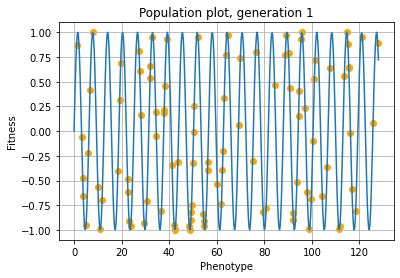

Average fitness of generation 1 is -0.07439930590250707
Population size 100
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1


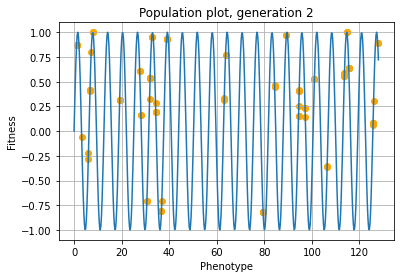

Average fitness of generation 2 is 0.3115197353181996
Population size 100
age = 1
age = 2
age = 1
age = 1
age = 1
age = 2
age = 2
age = 2
age = 2
age = 2
age = 1
age = 1
age = 3
age = 1
age = 1
age = 2
age = 2
age = 1
age = 1
age = 1
age = 3
age = 2
age = 1
age = 2
age = 2
age = 2
age = 3
age = 1
age = 1
age = 2
age = 4
age = 2
age = 1
age = 1
age = 2
age = 1
age = 3
age = 1
age = 1
age = 1
age = 2
age = 1
age = 2
age = 1
age = 2
age = 2
age = 2
age = 3
age = 2
age = 1
age = 1
age = 1
age = 2
age = 3
age = 2
age = 2
age = 2
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 1
age = 1
age = 1
age = 2
age = 1
age = 3
age = 2
age = 2
age = 3
age = 1
age = 1
age = 2
age = 2
age = 3
age = 1
age = 2
age = 2
age = 1
age = 2
age = 2
age = 1
age = 2
age = 1
age = 2
age = 1
age = 1
age = 1
age = 1
age = 2
age = 2
age = 1
age = 2
age = 2
age = 3
age = 1
age = 1
age = 1


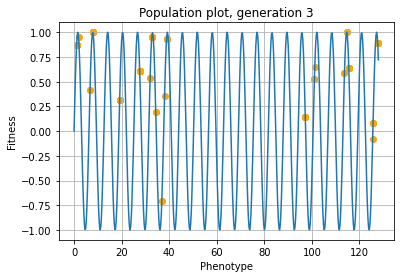

Average fitness of generation 3 is 0.6317306459175234
Population size 100
age = 2
age = 1
age = 1
age = 3
age = 1
age = 3
age = 1
age = 1
age = 3
age = 4
age = 2
age = 1
age = 1
age = 1
age = 2
age = 1
age = 3
age = 2
age = 4
age = 1
age = 1
age = 2
age = 1
age = 2
age = 2
age = 1
age = 4
age = 1
age = 3
age = 1
age = 1
age = 3
age = 2
age = 1
age = 5
age = 4
age = 1
age = 1
age = 4
age = 1
age = 4
age = 4
age = 1
age = 1
age = 2
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 2
age = 3
age = 2
age = 2
age = 2
age = 2
age = 1
age = 1
age = 3
age = 2
age = 3
age = 2
age = 1
age = 3
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 3
age = 3
age = 1
age = 1
age = 1
age = 1
age = 3
age = 1
age = 1
age = 2
age = 1
age = 2
age = 2
age = 3
age = 2
age = 1
age = 1
age = 2
age = 2
age = 1
age = 3
age = 1
age = 1
age = 1
age = 2
age = 4
age = 1
age = 5
age = 2


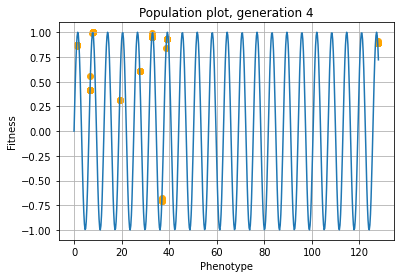

Average fitness of generation 4 is 0.752346266393663
Population size 100
age = 5
age = 6
age = 1
age = 2
age = 3
age = 1
age = 3
age = 3
age = 1
age = 2
age = 1
age = 2
age = 1
age = 2
age = 1
age = 1
age = 1
age = 1
age = 5
age = 1
age = 5
age = 1
age = 5
age = 6
age = 3
age = 1
age = 7
age = 8
age = 1
age = 4
age = 9
age = 5
age = 1
age = 3
age = 2
age = 1
age = 3
age = 4
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 2
age = 1
age = 1
age = 3
age = 3
age = 4
age = 2
age = 1
age = 2
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 2
age = 5
age = 5
age = 5
age = 1
age = 1
age = 2
age = 5
age = 1
age = 6
age = 3
age = 2
age = 2
age = 3
age = 2
age = 1
age = 1
age = 1
age = 2
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 3
age = 1
age = 4
age = 4
age = 5
age = 1
age = 1
age = 1
age = 2
age = 1
age = 1
age = 1
age = 2
age = 3
age = 4


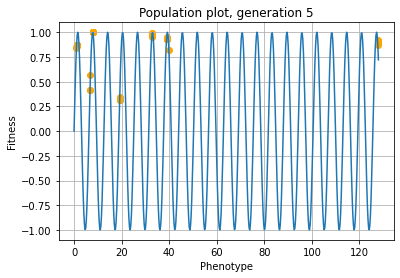

Average fitness of generation 5 is 0.8855411321544889
Population size 100
age = 7
age = 1
age = 1
age = 8
age = 2
age = 4
age = 1
age = 5
age = 1
age = 1
age = 1
age = 2
age = 3
age = 1
age = 1
age = 2
age = 2
age = 1
age = 4
age = 1
age = 1
age = 1
age = 2
age = 2
age = 2
age = 3
age = 6
age = 2
age = 1
age = 2
age = 3
age = 10
age = 1
age = 1
age = 6
age = 6
age = 6
age = 7
age = 6
age = 1
age = 2
age = 5
age = 7
age = 1
age = 1
age = 1
age = 2
age = 1
age = 2
age = 1
age = 2
age = 3
age = 2
age = 1
age = 1
age = 3
age = 1
age = 4
age = 1
age = 1
age = 1
age = 1
age = 2
age = 1
age = 2
age = 1
age = 1
age = 2
age = 2
age = 1
age = 1
age = 3
age = 4
age = 5
age = 1
age = 3
age = 2
age = 1
age = 2
age = 4
age = 3
age = 1
age = 3
age = 4
age = 5
age = 1
age = 2
age = 1
age = 1
age = 2
age = 1
age = 1
age = 1
age = 1
age = 1
age = 4
age = 1
age = 2
age = 2
age = 1


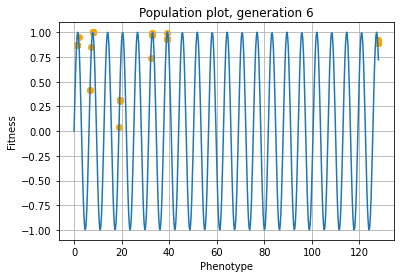

Average fitness of generation 6 is 0.8525487361780801
Population size 100
age = 6
age = 6
age = 7
age = 1
age = 2
age = 1
age = 3
age = 1
age = 2
age = 4
age = 3
age = 1
age = 1
age = 2
age = 3
age = 1
age = 1
age = 1
age = 1
age = 3
age = 2
age = 2
age = 1
age = 1
age = 1
age = 3
age = 1
age = 1
age = 1
age = 2
age = 1
age = 3
age = 1
age = 7
age = 1
age = 7
age = 3
age = 8
age = 3
age = 1
age = 4
age = 2
age = 1
age = 2
age = 1
age = 5
age = 2
age = 3
age = 3
age = 1
age = 1
age = 3
age = 1
age = 1
age = 2
age = 2
age = 1
age = 1
age = 3
age = 1
age = 1
age = 1
age = 3
age = 1
age = 1
age = 5
age = 4
age = 3
age = 1
age = 5
age = 1
age = 6
age = 6
age = 6
age = 1
age = 7
age = 1
age = 1
age = 4
age = 1
age = 1
age = 4
age = 5
age = 1
age = 3
age = 1
age = 1
age = 3
age = 1
age = 2
age = 1
age = 3
age = 3
age = 3
age = 3
age = 1
age = 4
age = 1
age = 1
age = 1


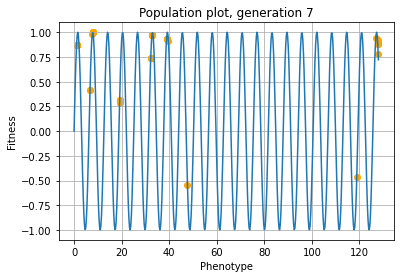

Average fitness of generation 7 is 0.8395260618652002
Population size 100
age = 2
age = 2
age = 1
age = 1
age = 1
age = 2
age = 1
age = 1
age = 2
age = 4
age = 1
age = 4
age = 5
age = 1
age = 4
age = 5
age = 5
age = 2
age = 6
age = 1
age = 1
age = 1
age = 1
age = 2
age = 3
age = 2
age = 1
age = 6
age = 2
age = 3
age = 2
age = 1
age = 1
age = 1
age = 2
age = 4
age = 1
age = 7
age = 1
age = 2
age = 5
age = 3
age = 4
age = 5
age = 2
age = 3
age = 1
age = 5
age = 2
age = 1
age = 6
age = 1
age = 4
age = 7
age = 1
age = 3
age = 1
age = 8
age = 1
age = 5
age = 5
age = 6
age = 1
age = 1
age = 1
age = 1
age = 8
age = 1
age = 1
age = 2
age = 8
age = 3
age = 2
age = 1
age = 1
age = 2
age = 1
age = 5
age = 1
age = 4
age = 5
age = 6
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 3
age = 1
age = 5
age = 2
age = 1
age = 5
age = 1
age = 6
age = 2
age = 1
age = 1
age = 1


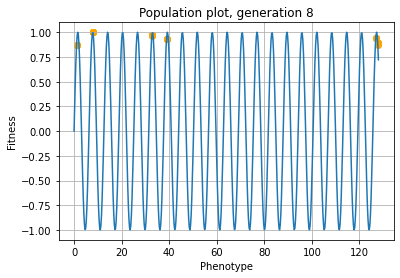

Average fitness of generation 8 is 0.9321246558929581
Population size 100
age = 1
age = 1
age = 2
age = 3
age = 4
age = 3
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 7
age = 3
age = 1
age = 8
age = 9
age = 1
age = 7
age = 8
age = 2
age = 2
age = 3
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 2
age = 3
age = 1
age = 4
age = 1
age = 2
age = 1
age = 1
age = 1
age = 2
age = 1
age = 1
age = 1
age = 3
age = 4
age = 5
age = 1
age = 6
age = 3
age = 1
age = 1
age = 2
age = 1
age = 8
age = 2
age = 4
age = 9
age = 1
age = 2
age = 3
age = 4
age = 4
age = 1
age = 6
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 8
age = 1
age = 6
age = 1
age = 1
age = 1
age = 8
age = 2
age = 2
age = 7
age = 8
age = 2
age = 9
age = 8
age = 2
age = 9
age = 6
age = 1
age = 1
age = 1
age = 2
age = 1
age = 3
age = 2
age = 1
age = 1
age = 6
age = 2
age = 1
age = 1


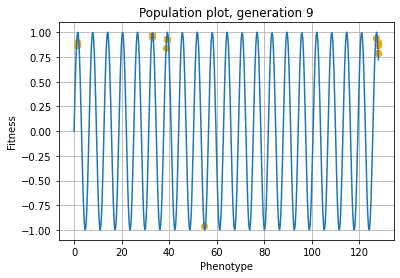

Average fitness of generation 9 is 0.8896269331129955
Population size 100
age = 1
age = 9
age = 2
age = 1
age = 2
age = 2
age = 10
age = 3
age = 1
age = 2
age = 1
age = 1
age = 4
age = 1
age = 2
age = 1
age = 1
age = 1
age = 1
age = 3
age = 3
age = 3
age = 1
age = 1
age = 1
age = 2
age = 1
age = 1
age = 10
age = 10
age = 11
age = 1
age = 3
age = 2
age = 1
age = 5
age = 1
age = 1
age = 3
age = 6
age = 7
age = 1
age = 1
age = 1
age = 2
age = 2
age = 3
age = 2
age = 1
age = 1
age = 1
age = 3
age = 1
age = 1
age = 1
age = 2
age = 1
age = 10
age = 1
age = 9
age = 3
age = 1
age = 2
age = 1
age = 2
age = 3
age = 1
age = 1
age = 10
age = 2
age = 1
age = 3
age = 1
age = 3
age = 4
age = 3
age = 3
age = 1
age = 2
age = 1
age = 1
age = 5
age = 1
age = 4
age = 4
age = 1
age = 5
age = 6
age = 7
age = 1
age = 2
age = 3
age = 2
age = 1
age = 2
age = 1
age = 1
age = 1
age = 1
age = 1


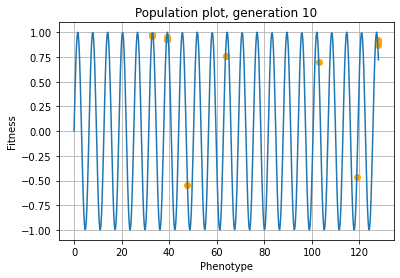

Average fitness of generation 10 is 0.8903676027563446
Population size 100
age = 2
age = 2
age = 3
age = 1
age = 11
age = 1
age = 1
age = 1
age = 1
age = 2
age = 2
age = 1
age = 4
age = 1
age = 5
age = 1
age = 3
age = 2
age = 1
age = 2
age = 1
age = 2
age = 1
age = 2
age = 1
age = 1
age = 2
age = 1
age = 1
age = 2
age = 3
age = 1
age = 1
age = 3
age = 3
age = 3
age = 4
age = 3
age = 1
age = 1
age = 12
age = 1
age = 2
age = 1
age = 13
age = 2
age = 1
age = 7
age = 7
age = 1
age = 2
age = 1
age = 7
age = 7
age = 1
age = 7
age = 2
age = 8
age = 6
age = 9
age = 1
age = 1
age = 8
age = 1
age = 2
age = 2
age = 1
age = 1
age = 3
age = 3
age = 1
age = 11
age = 1
age = 4
age = 1
age = 2
age = 12
age = 1
age = 1
age = 2
age = 13
age = 3
age = 1
age = 2
age = 1
age = 1
age = 3
age = 6
age = 4
age = 5
age = 6
age = 1
age = 7
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1


In [794]:
# choose survivor selection method. Either 'age' or 'tournament'

population = sga(survivor_selection = 'tournament', population=population)

## Check how many duplicates

In [795]:
import statistics
from statistics import mode

def most_common_and_count(lst):
    most_common_obj = mode(lst)
    count = lst.count(most_common_obj)
    return most_common_obj, count

# Example usage with your population list
most_common_obj, count = most_common_and_count(population)
print(f"The most common object is: {most_common_obj}")
print(f"It appears {count} times in the population.")


The most common object is: Individual(genotype=1111111101100111001011110100010101101111100001010101100001001100001111, phenotype=1177838744162757120783, sin_fitness=1.892909401283167)
It appears 14 times in the population.


*f) This task is identical to e), however, we now add the constraint that the
solution must reside in the interval [5,10]. The constraint should not be
handled by scaling the real value of the bitstring into the new interval.
Throughout the generations plot the individuals, values and fitness values with
the sine wave.*